# Overview

-This notebook contains the code relevant to the second chapter

In [44]:
import hashlib
import os
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import requests

In [2]:
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL= 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'

def fetch_housing_data(housing_url, housing_path):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    r = requests.get(housing_url)
    file = os.path.join(housing_path, 'housing.tgz')
    with open(file, 'wb') as f:
        f.write(r.content)
    with tarfile.open(file) as f:
        f.extractall(path=housing_path)
        
def load_housing_data(housing_file):
    return pd.read_csv(housing_file)
        

In [3]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

In [6]:
data = load_housing_data(HOUSING_PATH+ '/' + 'housing.csv')

In [7]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [14]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa39c458978>,
      dtype=object)

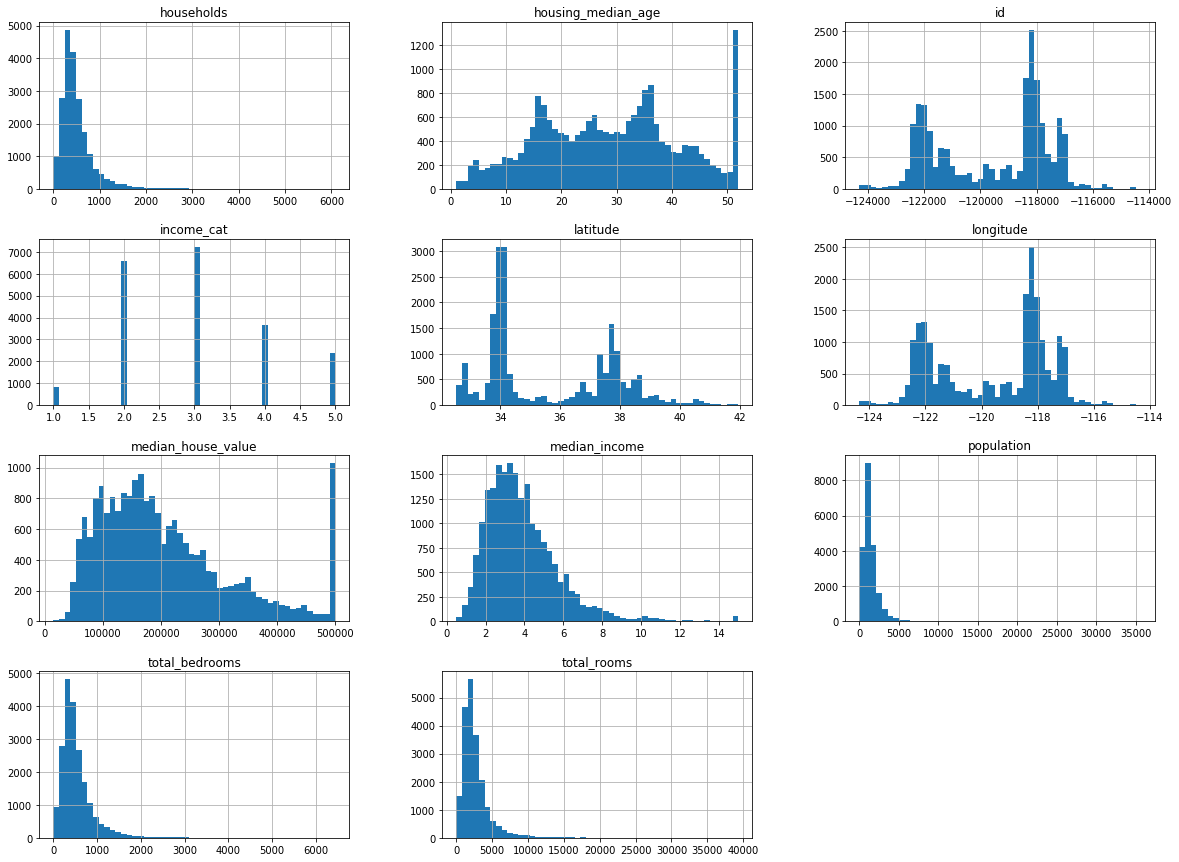

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

When training and validating, we want different sets of data. There are a few ways of doing this:

1. shuffle the data and segment via a ratio
2. create a distribution of hashes for each record id. Segment that by the ratio
3. use an sklearn helper functiopn

In [20]:
# 1. 

def split_training_set(data, test_ratio):
    shuffled = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indices = shuffled[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [33]:
# 2.
# Using np.random is non-deterministic unless we use the same seed.
# However, if the dataset changes, we will get different test/train sets
# To solve this, assume the id is constant. If we hash the id, and bucket these
# hashes according to the test_ratio get a deterministic + 

def test_set_check(_id, test_ratio, hash):
    return hash(np.int64(_id)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda _id: test_set_check(_id, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [35]:
data['id'] = data['longitude'] * 1000 + data['latitude']
train_data, test_data = split_train_test_by_id(data, 0.2, 'id')
print(f'Training set : {len(train_data)} , Test data : {len(test_data)}')

Training set : 16267 , Test data : 4373


In [39]:
# 3.
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Creating income strata



In [61]:
data['income_cat'] = np.ceil(data['median_income'] / 1.5)
data['income_cat'].where(data['income_cat'] < 5, 5.0, inplace=True)

In [59]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15,5.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15,5.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15,5.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,-122212.16,5.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,-122212.16,5.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16,5.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,-122212.16,5.0


In [57]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['income_cat']):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [54]:
# TODO : How to get their Figure 2.10
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

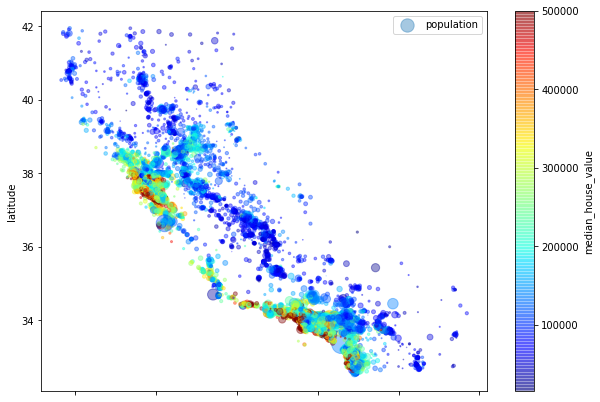

In [72]:
# Data visualization
data = strat_train_set.copy()
data
data.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=data['population']/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
    colorbar=True
)